In [1]:
# Python
# Third
# Property
from ls_lib import *

pd.set_option('display.max_rows', 150)


### TODO
- Type hint
- Field
- Optional
- Document functions
- Pytest/Unit Tests (Udacity content)
- log (Udacity content)

In [2]:
# Parameters
LST_B3_STOCKS = ["RRRP3", "ALOS3", "ALPA4", "ABEV3", "ASAI3", "AZUL4", "AZZA3", "B3SA3", "BBSE3", "BBDC3", "BBDC4", "BRAP4", "BBAS3", "BRKM5", "BRFS3", "BPAC11", "CRFB3", "CCRO3", "CMIG4", "COGN3", "CPLE6", "CSAN3", "CPFE3", "CMIN3", "CVCB3", "CYRE3", "DXCO3", "ELET3", "ELET6", "EMBR3", "ENGI11", "ENEV3", "EGIE3", "EQTL3", "EZTC3", "FLRY3", "GGBR4", "GOAU4", "NTCO3", "HAPV3", "HYPE3", "IGTI11", "IRBR3", "ITSA4", "ITUB4", "JBSS3", "KLBN11", "RENT3", "LREN3", "LWSA3", "MGLU3", "MRFG3", "BEEF3", "MRVE3", "MULT3", "PCAR3", "PETR3", "PETR4", "RECV3", "PRIO3", "PETZ3", "RADL3", "RAIZ4", "RDOR3", "RAIL3", "SBSP3", "SANB11", "SMTO3", "CSNA3", "SLCE3", "SUZB3", "TAEE11", "VIVT3", "TIMS3", "TOTS3", "TRPL4", "UGPA3", "USIM5", "VALE3", "VAMO3", "VBBR3", "VIVA3", "WEGE3", "YDUQ3"]
PATH_LS_DATA = 'ls_data/'

In [ ]:
create_long_short_dataset(LST_B3_STOCKS, "2018-01-01", None, source = 'yahoo')

## L&S Screaning

Gerênciamento de risco
- 160 períodos: 1/3 do Capital para cada trade.
- 200 períodos: 1/2 do Capital para cada trade.
- 252 períodos: 100% do Capital para cada trade.


Teste ADF
- 1% -4,32%
- 5% -3,78%
- 10% -3,50%

Interpretação do Beta
- Para cada 1 real do ativo 1, operar beta*reais do ativo 2

In [357]:
#["2024-02-12","2024-02-13","2024-03-29","2024-05-01","2024-05-30","2024-11-15","2024-12-24","2024-12-25","2024-12-31"]

In [8]:
# Filtro dataset
df_stocks = load_long_short_dataset(max_date = "2024-02-23")
lst_pairs = getPairs(df_stocks)
periods = 200
date_col = 'date'

args = [{"pair":pair, "dataset": df_stocks, "periods": periods, "date_col": date_col} for pair in lst_pairs]

df_stats = getPairsResiduals(args, df_stocks, 'date', periods, workers = 8)
df_stats["periodo"] = periods

# Screaning
df_screaning = df_stats[
    (df_stats['adf'] <= -3.78) & 
    (abs(df_stats['desv']) >= 1.80) & 
    (abs(df_stats['desv']) < 2.5) & 
    (df_stats['beta'] >= 0.5) & 
    (df_stats['beta'] < 2) & 
    (df_stats['halflife'] <= 10)]

df_screaning["beta_parity"] = abs(df_screaning["beta"]-1)

df_screaning = df_screaning.sort_values(by='beta_parity').drop(columns=['beta_parity'])

df_screaning = double_cointegration(df_screaning, check = True)

df_screaning.reset_index(drop=True)

,pair,adf,beta,desv,halflife,p_value,periodo
0,ENEV3/CRFB3,-4.428333,1.29,2.49,6.0,99.97,200
1,BRFS3/TIMS3,-4.704825,0.63,2.33,5.0,99.99,200
2,TIMS3/BRFS3,-4.537730,1.40,-1.82,5.0,99.98,200
3,BPAC11/EQTL3,-3.946433,0.52,-1.93,5.0,99.83,200
4,CRFB3/ENEV3,-3.816949,0.50,-2.08,5.0,99.73,200
5,EQTL3/BPAC11,-3.988162,1.63,2.30,6.0,99.85,200


0
ENEV3/CRFB3
Beta:  1.29
Desv:  2.49
Halflife:  6.0


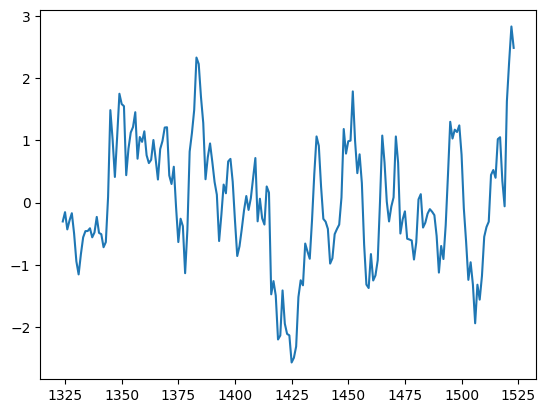

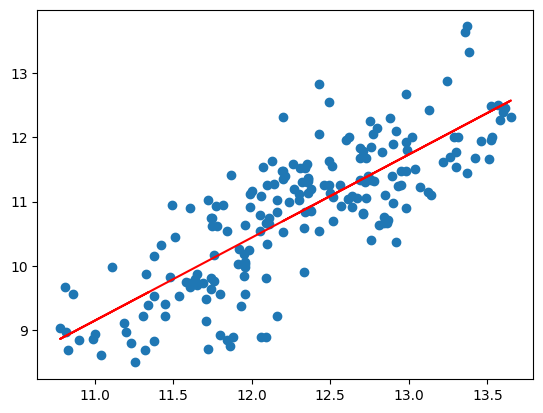

1
BRFS3/TIMS3
Beta:  0.63
Desv:  2.33
Halflife:  5.0


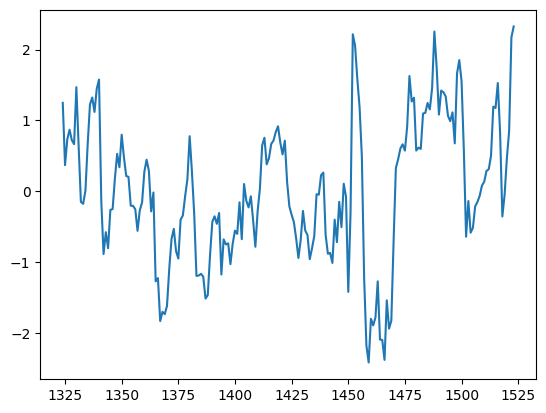

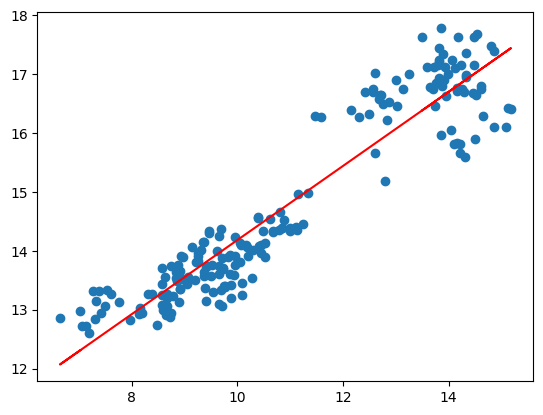

2
TIMS3/BRFS3
Beta:  1.4
Desv:  -1.82
Halflife:  5.0


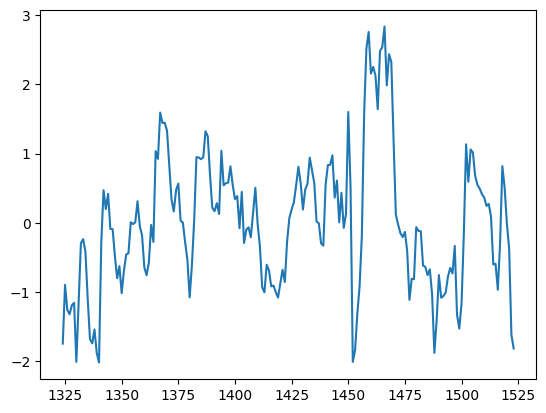

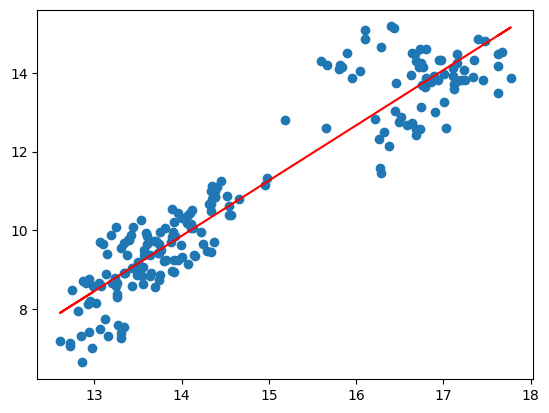

3
BPAC11/EQTL3
Beta:  0.52
Desv:  -1.93
Halflife:  5.0


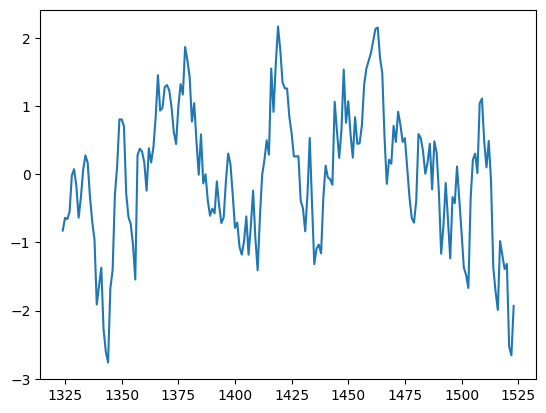

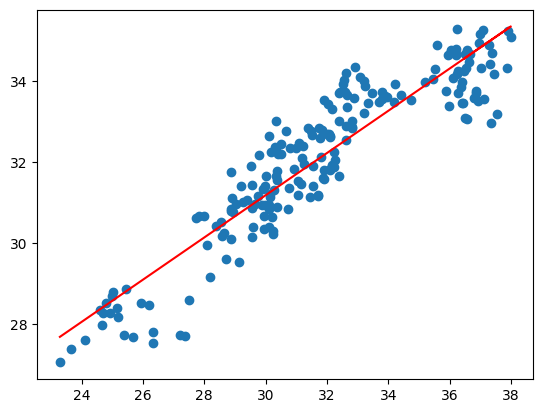

4
CRFB3/ENEV3
Beta:  0.5
Desv:  -2.08
Halflife:  5.0


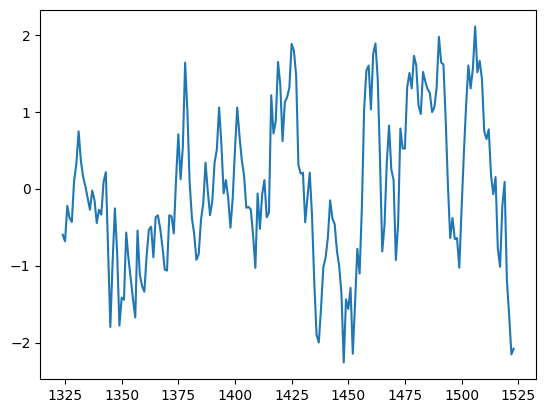

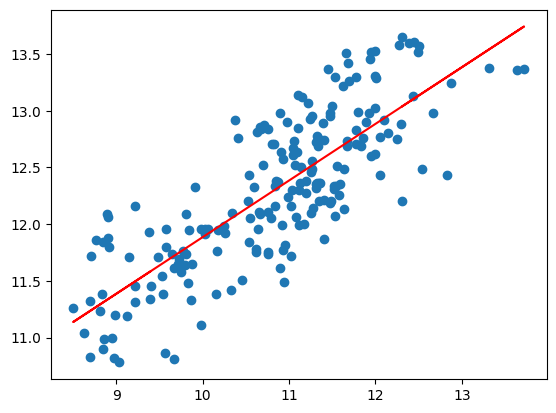

5
EQTL3/BPAC11
Beta:  1.63
Desv:  2.3
Halflife:  6.0


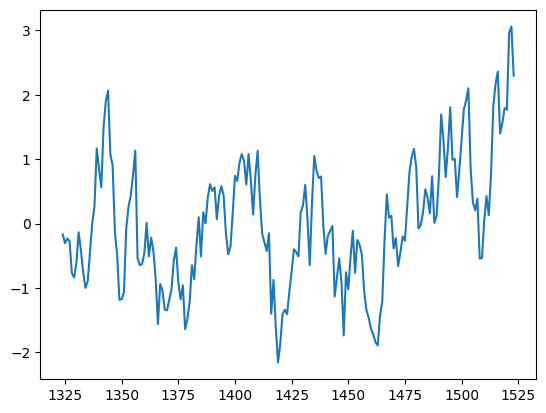

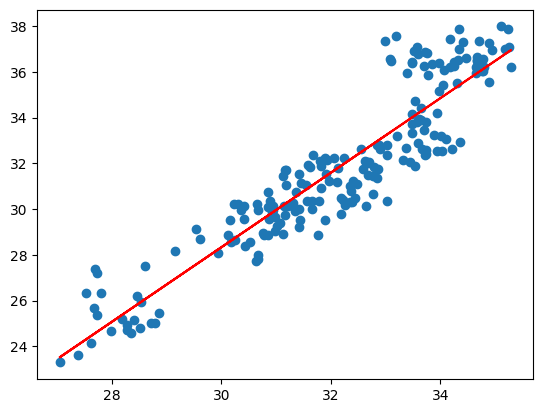

In [9]:
for n_pair in range(len(df_screaning)):
    print(n_pair)
    print(df_screaning.iloc[n_pair,0])
    print("Beta: ", df_screaning.iloc[n_pair,2])
    print("Desv: ", df_screaning.iloc[n_pair,3])
    print("Halflife: ", df_screaning.iloc[n_pair,4])

    # Residual
    asset1 = df_screaning.iloc[n_pair,0].split('/')[0]
    asset2 = df_screaning.iloc[n_pair,0].split('/')[1]
    df_res = df_stocks[[date_col, asset1, asset2]].sort_values(by=date_col, ascending=False)[:periods]
    X = df_res.iloc[:, 1].values.reshape(-1, 1)
    Y = df_res.iloc[:, 2].values.reshape(-1, 1)
    linear_regressor = LinearRegression()
    linear_regressor.fit(X, Y)

    Y_pred = linear_regressor.predict(X)
    df_res[asset1+'/'+asset2] = Y - Y_pred  # Residuals

    df_res = df_res[[date_col, asset1+'/'+asset2]]
    
    df_res_aux = normalize_column(df_res, asset1+'/'+asset2)

    plt.plot(df_res_aux)
    plt.show()

    # Regression
    plt.scatter(X, Y)
    plt.plot(X, Y_pred, color='red')
    plt.show()

In [13]:
from datetime import datetime, timedelta

def generate_workdays_list(start_date, end_date):
    # Convert the input strings to datetime objects
    start = datetime.strptime(start_date, '%Y-%m-%d')
    end = datetime.strptime(end_date, '%Y-%m-%d')
    
    # Generate the list of workdays
    workdays_list = []
    while start <= end:
        if start.weekday() < 5:  # Monday = 0, Sunday = 6
            workdays_list.append(start.strftime('%Y-%m-%d'))
        start += timedelta(days=1)
    
    return workdays_list

lst_dates = generate_workdays_list("2024-08-01", "2024-08-23")

lst_holydays = ["2024-01-01","2024-02-12","2024-02-13","2024-03-29","2024-05-01","2024-05-30","2024-11-15","2024-12-24","2024-12-25","2024-12-31"]

lst_dates = [item for item in lst_dates if item not in lst_holydays]

lst_df_pairs_stats = []

for trading_date in lst_dates:
    print(trading_date)
    # Filtro dataset
    df_stocks = load_long_short_dataset(max_date = trading_date)
    lst_pairs = getPairs(df_stocks)
    periods = 200
    date_col = 'date'

    args = [{"pair":pair, "dataset": df_stocks, "periods": periods, "date_col": date_col} for pair in lst_pairs]

    df_stats = getPairsResiduals(args, df_stocks, 'date', periods, workers = 8)
    df_stats["periodo"] = periods

    # Screaning
    df_screaning = df_stats[
        (df_stats['adf'] <= -3.78) & 
        (abs(df_stats['desv']) >= 1.80) & 
        (abs(df_stats['desv']) < 2.5) & 
        (df_stats['beta'] >= 0.5) & 
        (df_stats['beta'] < 2) & 
        (df_stats['halflife'] <= 10)]

    df_screaning["beta_parity"] = abs(df_screaning["beta"]-1)

    df_screaning = df_screaning.sort_values(by='beta_parity').drop(columns=['beta_parity'])

    df_screaning = double_cointegration(df_screaning, check = True)

    df_screaning.reset_index(drop=True)
    
    df_screaning["trade_date"] = trading_date

    lst_df_pairs_stats.append(df_screaning)


    
df_backtest = pd.concat(lst_df_pairs_stats, ignore_index=True)

df_backtest.to_csv(PATH_LS_DATA+'yahoo_long_short_backtest.csv')

df_backtest

2024-08-01
2024-08-02
2024-08-05
2024-08-06
2024-08-07
2024-08-08
2024-08-09
2024-08-12
2024-08-13
2024-08-14
2024-08-15
2024-08-16
2024-08-19
2024-08-20
2024-08-21
2024-08-22
2024-08-23


,pair,adf,beta,desv,halflife,p_value,periodo,trade_date
0,BPAC11/ELET6,-4.060949,1.01,2.34,6.0,99.89,200,2024-08-01
1,ELET6/BPAC11,-4.154833,0.80,-2.31,5.0,99.92,200,2024-08-01
2,VIVT3/ELET3,-4.365770,0.90,-2.05,5.0,99.97,200,2024-08-02
3,ELET3/VIVT3,-4.479774,0.89,2.15,4.0,99.98,200,2024-08-02
4,COGN3/ABEV3,-4.192405,1.23,2.01,5.0,99.93,200,2024-08-02
5,ABEV3/COGN3,-4.209544,0.70,-2.49,5.0,99.94,200,2024-08-02
6,B3SA3/BBDC4,-4.281208,0.92,1.90,4.0,99.95,200,2024-08-05
7,BBDC4/B3SA3,-4.196530,0.89,-2.13,4.0,99.93,200,2024-08-05
8,ABEV3/BBDC3,-3.890718,1.19,1.81,6.0,99.79,200,2024-08-05
9,TIMS3/NTCO3,-3.916285,1.21,-1.90,6.0,99.81,200,2024-08-05
